# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

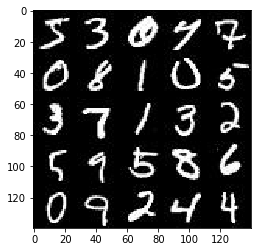

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

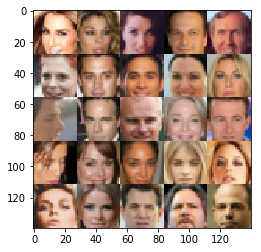

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input = tf.placeholder( tf.float32, [None,image_width,image_height,image_channels], name='input_real')
    z_input = tf.placeholder( tf.float32, [None,z_dim], name='input_z' )
    learning_rate = tf.placeholder( tf.float32, name='learning_rate' )
    return input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [14]:
def discriminator(images, reuse=False, alpha=0.1, dropout_rate=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        #print( images.shape )
        images = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        images = tf.maximum( alpha*images, images )
        # 14*14*64
        #print( images.shape )
        images = tf.layers.conv2d(inputs=images, filters=256, kernel_size=5, strides=2, padding='same')
        images = tf.layers.batch_normalization(images, training=True)
        images = tf.maximum( alpha*images, images )
        # 7*7*128
        #print( images.shape )
        images = tf.layers.conv2d(inputs=images, filters=512, kernel_size=5, strides=2, padding='same')
        images = tf.layers.batch_normalization(images, training=True)
        images = tf.maximum( alpha*images, images )
        # 4x4x256
        #print( images.shape )
        flat = tf.reshape(images, (-1, 4*4*512 ) )
        dropout = tf.layers.dropout(flat, dropout_rate)
        logits = tf.layers.dense(dropout,1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        #print( z.shape )
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1, 4, 4, 512) )
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # 4x4x512
        #print( x.shape ) 
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # 8x8x256
        #print( x.shape ) 
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # 16x16x64
        #print( x.shape ) 
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x5
        logits = tf.image.resize_images(logits, (28,28) )
        #print( logits.shape )
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Get weights and bias to update
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.1):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, lrate = model_inputs(data_shape[1], data_shape[2], 3 if data_image_mode == "RGB" else 1, z_dim )
    d_loss, g_loss = model_loss( input_real, input_z, data_shape[3], alpha )
    d_opt, g_opt = model_opt( d_loss, g_loss, lrate, beta1 )
    
    n_images = 16
    show_every = 50
    print_every = 10
    
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = np.dot( batch_images, 2 )
                steps += 1
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                feed = { input_real: batch_images, input_z: batch_z, lrate: learning_rate }
                _ = sess.run( d_opt, feed_dict=feed)
                _ = sess.run( g_opt, feed_dict=feed)
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed)
                    train_loss_g = g_loss.eval(feed)
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1368... Generator Loss: 5.3391
Epoch 1/2... Discriminator Loss: 0.0703... Generator Loss: 3.4105
Epoch 1/2... Discriminator Loss: 0.1214... Generator Loss: 14.6349
Epoch 1/2... Discriminator Loss: 0.4984... Generator Loss: 15.6009
Epoch 1/2... Discriminator Loss: 0.1382... Generator Loss: 9.7742


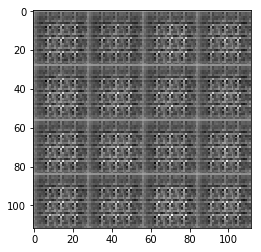

Epoch 1/2... Discriminator Loss: 0.0715... Generator Loss: 5.4143
Epoch 1/2... Discriminator Loss: 3.8619... Generator Loss: 0.0804
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 1.8911... Generator Loss: 4.9813
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.4991


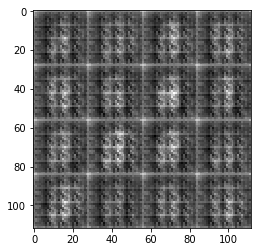

Epoch 1/2... Discriminator Loss: 0.5208... Generator Loss: 1.4414
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 1.7780
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 2.7457
Epoch 1/2... Discriminator Loss: 0.4085... Generator Loss: 2.4636
Epoch 1/2... Discriminator Loss: 0.4709... Generator Loss: 1.9210


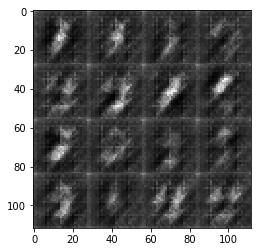

Epoch 1/2... Discriminator Loss: 0.4235... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 0.4631... Generator Loss: 1.9507
Epoch 1/2... Discriminator Loss: 0.5345... Generator Loss: 3.0244
Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 3.8938


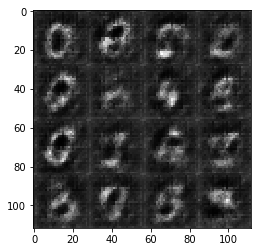

Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 2.2745
Epoch 1/2... Discriminator Loss: 1.8958... Generator Loss: 4.9887
Epoch 1/2... Discriminator Loss: 0.5159... Generator Loss: 1.4776
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 1.1178
Epoch 1/2... Discriminator Loss: 0.4894... Generator Loss: 1.6945


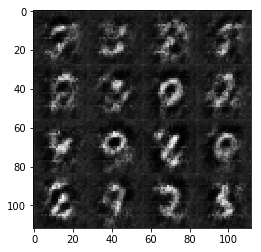

Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 0.4432... Generator Loss: 1.9750
Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 2.0320
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 1.0854
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 1.6851


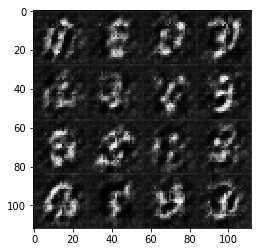

Epoch 1/2... Discriminator Loss: 0.5129... Generator Loss: 1.4841
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 2.8819
Epoch 1/2... Discriminator Loss: 0.4517... Generator Loss: 1.5800
Epoch 1/2... Discriminator Loss: 0.4283... Generator Loss: 1.9896
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 2.2556


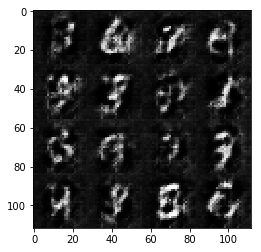

Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 2.0701
Epoch 1/2... Discriminator Loss: 0.3252... Generator Loss: 1.9984
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 2.6364
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 1.3309


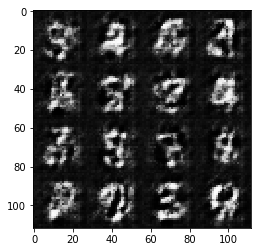

Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 3.0989
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 1.9346
Epoch 1/2... Discriminator Loss: 0.4619... Generator Loss: 2.4153
Epoch 1/2... Discriminator Loss: 0.3462... Generator Loss: 1.9932
Epoch 1/2... Discriminator Loss: 0.2653... Generator Loss: 2.4072


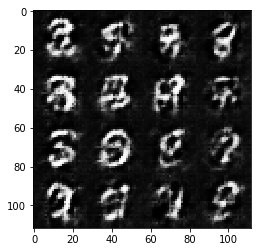

Epoch 1/2... Discriminator Loss: 0.3736... Generator Loss: 2.3084
Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 2.2526
Epoch 1/2... Discriminator Loss: 0.3056... Generator Loss: 2.4325
Epoch 1/2... Discriminator Loss: 0.3068... Generator Loss: 2.2588
Epoch 1/2... Discriminator Loss: 0.2537... Generator Loss: 1.9753


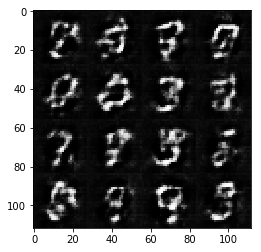

Epoch 1/2... Discriminator Loss: 0.4653... Generator Loss: 3.1073
Epoch 1/2... Discriminator Loss: 0.3489... Generator Loss: 1.7605
Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 3.4305
Epoch 1/2... Discriminator Loss: 0.2742... Generator Loss: 2.2882
Epoch 1/2... Discriminator Loss: 0.4127... Generator Loss: 3.6269


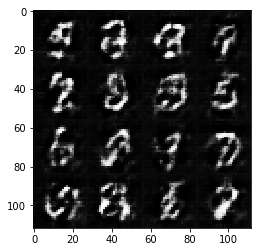

Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 2.1429
Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 2.0691
Epoch 1/2... Discriminator Loss: 0.2817... Generator Loss: 1.9142
Epoch 1/2... Discriminator Loss: 0.2289... Generator Loss: 2.6376


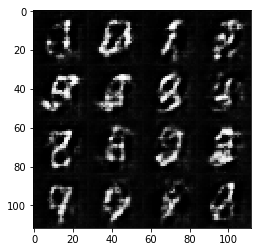

Epoch 1/2... Discriminator Loss: 0.2302... Generator Loss: 2.4555
Epoch 1/2... Discriminator Loss: 0.4513... Generator Loss: 3.7107
Epoch 1/2... Discriminator Loss: 0.3048... Generator Loss: 1.8274
Epoch 1/2... Discriminator Loss: 0.2116... Generator Loss: 2.6954
Epoch 1/2... Discriminator Loss: 0.7488... Generator Loss: 0.7931


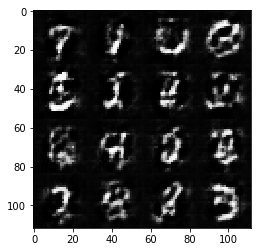

Epoch 1/2... Discriminator Loss: 0.2990... Generator Loss: 2.1927
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 0.9545
Epoch 1/2... Discriminator Loss: 0.3651... Generator Loss: 1.7714
Epoch 1/2... Discriminator Loss: 0.2310... Generator Loss: 2.5449
Epoch 1/2... Discriminator Loss: 0.2765... Generator Loss: 2.0693


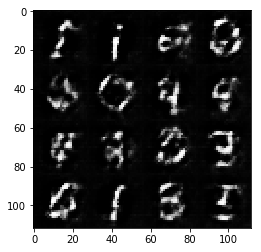

Epoch 1/2... Discriminator Loss: 3.4143... Generator Loss: 0.0860
Epoch 1/2... Discriminator Loss: 0.3145... Generator Loss: 1.9937
Epoch 1/2... Discriminator Loss: 0.2390... Generator Loss: 2.8860
Epoch 1/2... Discriminator Loss: 0.2050... Generator Loss: 2.4670
Epoch 1/2... Discriminator Loss: 0.3017... Generator Loss: 1.9858


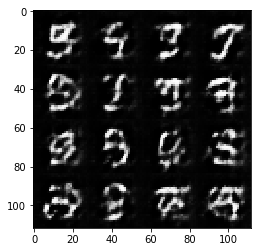

Epoch 1/2... Discriminator Loss: 0.2613... Generator Loss: 2.0736
Epoch 1/2... Discriminator Loss: 0.4811... Generator Loss: 2.9728
Epoch 1/2... Discriminator Loss: 0.6447... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 1.1262
Epoch 1/2... Discriminator Loss: 0.3835... Generator Loss: 1.5637


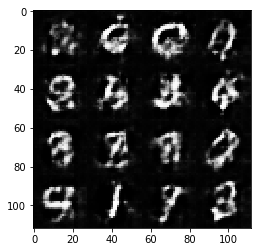

Epoch 1/2... Discriminator Loss: 0.2526... Generator Loss: 2.5384
Epoch 1/2... Discriminator Loss: 0.2913... Generator Loss: 2.2049
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 1.4240
Epoch 1/2... Discriminator Loss: 0.3219... Generator Loss: 1.8286
Epoch 1/2... Discriminator Loss: 0.2784... Generator Loss: 2.0900


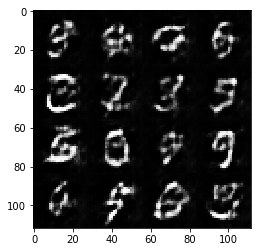

Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 4.8339
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 0.4796... Generator Loss: 3.1455
Epoch 1/2... Discriminator Loss: 0.3736... Generator Loss: 1.6867


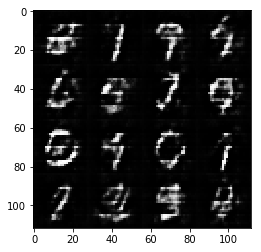

Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 1.4739
Epoch 1/2... Discriminator Loss: 0.2875... Generator Loss: 1.7351
Epoch 1/2... Discriminator Loss: 0.3273... Generator Loss: 1.9793
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 1.2488
Epoch 2/2... Discriminator Loss: 0.3453... Generator Loss: 2.1896


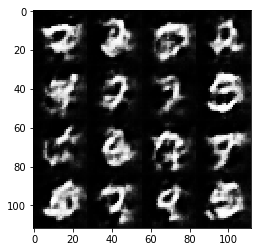

Epoch 2/2... Discriminator Loss: 0.3859... Generator Loss: 1.4986
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 1.6126
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.0694
Epoch 2/2... Discriminator Loss: 0.6302... Generator Loss: 3.3991


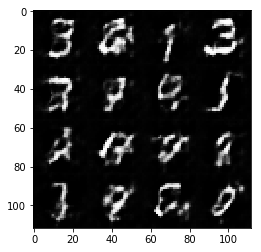

Epoch 2/2... Discriminator Loss: 0.2711... Generator Loss: 3.2484
Epoch 2/2... Discriminator Loss: 0.2197... Generator Loss: 2.2450
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 1.9716
Epoch 2/2... Discriminator Loss: 0.3132... Generator Loss: 2.0704
Epoch 2/2... Discriminator Loss: 0.2915... Generator Loss: 2.1610


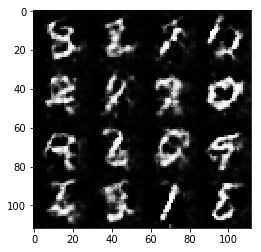

Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 1.9166
Epoch 2/2... Discriminator Loss: 0.3769... Generator Loss: 1.8138
Epoch 2/2... Discriminator Loss: 0.2951... Generator Loss: 1.9613
Epoch 2/2... Discriminator Loss: 0.6428... Generator Loss: 1.0916


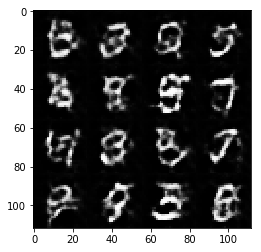

Epoch 2/2... Discriminator Loss: 0.2106... Generator Loss: 3.5945
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 3.0582
Epoch 2/2... Discriminator Loss: 0.4752... Generator Loss: 2.8528
Epoch 2/2... Discriminator Loss: 0.4880... Generator Loss: 2.6183
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 0.6765


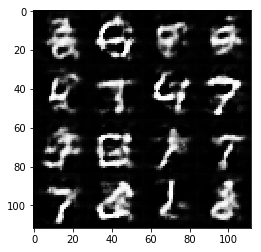

Epoch 2/2... Discriminator Loss: 0.3733... Generator Loss: 1.9528
Epoch 2/2... Discriminator Loss: 0.4224... Generator Loss: 1.8915
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.4115
Epoch 2/2... Discriminator Loss: 0.4773... Generator Loss: 2.6643
Epoch 2/2... Discriminator Loss: 0.2750... Generator Loss: 2.2489


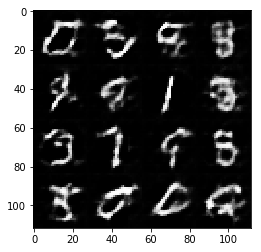

Epoch 2/2... Discriminator Loss: 0.2803... Generator Loss: 2.3155
Epoch 2/2... Discriminator Loss: 0.3911... Generator Loss: 2.2369
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 3.2685
Epoch 2/2... Discriminator Loss: 0.3525... Generator Loss: 1.9915
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 3.6775


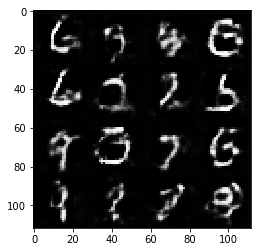

Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 0.4859... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 1.3975
Epoch 2/2... Discriminator Loss: 0.3713... Generator Loss: 2.0751
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 3.5288


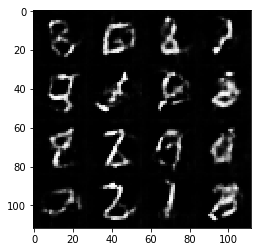

Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 2.5585
Epoch 2/2... Discriminator Loss: 0.6551... Generator Loss: 2.8623
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 2.8088
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 2.2282


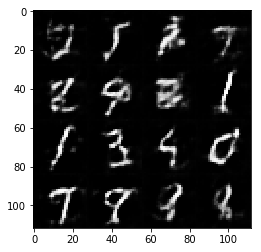

Epoch 2/2... Discriminator Loss: 0.4204... Generator Loss: 1.5379
Epoch 2/2... Discriminator Loss: 0.3187... Generator Loss: 2.6042
Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 1.8185
Epoch 2/2... Discriminator Loss: 0.3049... Generator Loss: 2.1014
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.0776


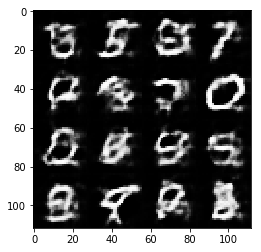

Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 2.4580
Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 0.3084... Generator Loss: 1.9410
Epoch 2/2... Discriminator Loss: 0.5690... Generator Loss: 2.5317


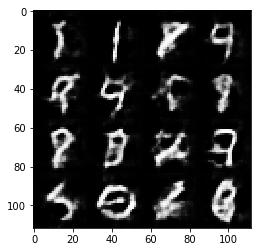

Epoch 2/2... Discriminator Loss: 0.6523... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 0.5610... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 2.7053
Epoch 2/2... Discriminator Loss: 0.3243... Generator Loss: 2.1006
Epoch 2/2... Discriminator Loss: 0.3586... Generator Loss: 1.7679


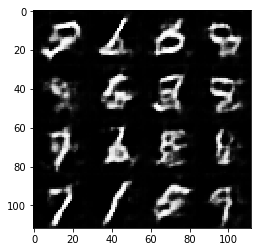

Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 1.9175
Epoch 2/2... Discriminator Loss: 0.2804... Generator Loss: 1.7902
Epoch 2/2... Discriminator Loss: 0.3733... Generator Loss: 2.0545
Epoch 2/2... Discriminator Loss: 0.3670... Generator Loss: 1.6629


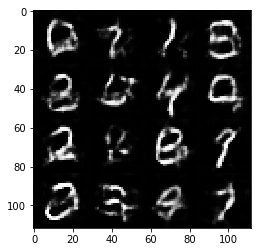

Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 1.6027
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 0.4773... Generator Loss: 1.7175
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 4.4429


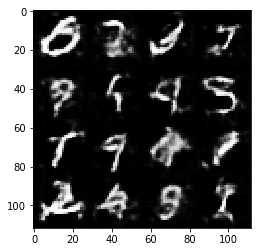

Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 0.3115... Generator Loss: 2.1249
Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 0.4494... Generator Loss: 2.6447
Epoch 2/2... Discriminator Loss: 0.6213... Generator Loss: 1.1227


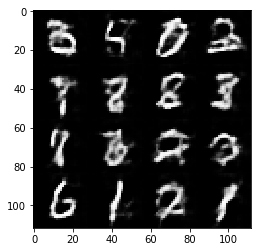

Epoch 2/2... Discriminator Loss: 0.3568... Generator Loss: 1.7670
Epoch 2/2... Discriminator Loss: 0.3535... Generator Loss: 1.7168
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 1.4981
Epoch 2/2... Discriminator Loss: 0.3794... Generator Loss: 1.6156
Epoch 2/2... Discriminator Loss: 0.6457... Generator Loss: 0.9072


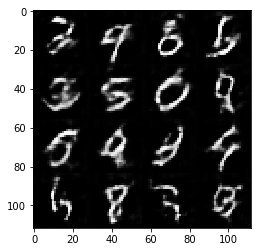

Epoch 2/2... Discriminator Loss: 0.4167... Generator Loss: 1.8014
Epoch 2/2... Discriminator Loss: 0.4779... Generator Loss: 1.4214
Epoch 2/2... Discriminator Loss: 2.4360... Generator Loss: 0.3205
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.9512
Epoch 2/2... Discriminator Loss: 0.3651... Generator Loss: 2.4773


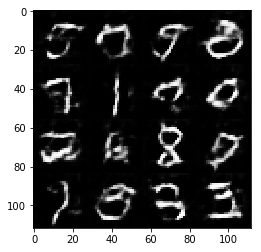

Epoch 2/2... Discriminator Loss: 0.2987... Generator Loss: 2.1224
Epoch 2/2... Discriminator Loss: 0.3258... Generator Loss: 1.8884
Epoch 2/2... Discriminator Loss: 0.3605... Generator Loss: 2.0429
Epoch 2/2... Discriminator Loss: 0.1738... Generator Loss: 2.3588
Epoch 2/2... Discriminator Loss: 0.7639... Generator Loss: 0.9766


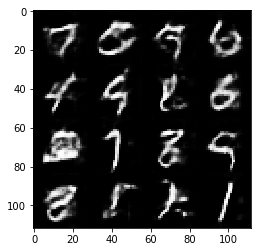

Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.2652
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 1.6520
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 1.7752
Epoch 2/2... Discriminator Loss: 0.3432... Generator Loss: 1.9370
Epoch 2/2... Discriminator Loss: 0.3219... Generator Loss: 1.8342


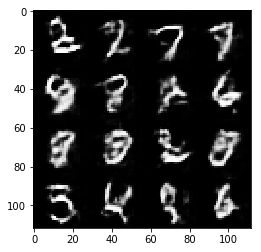

Epoch 2/2... Discriminator Loss: 0.3126... Generator Loss: 1.8659
Epoch 2/2... Discriminator Loss: 0.3493... Generator Loss: 1.6881


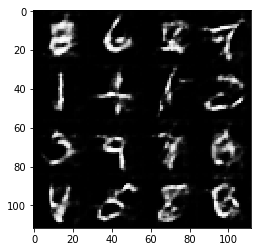

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
alpha = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1444... Generator Loss: 2.6631
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.2732
Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 3.3096
Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 3.1317
Epoch 1/1... Discriminator Loss: 0.1331... Generator Loss: 2.8648


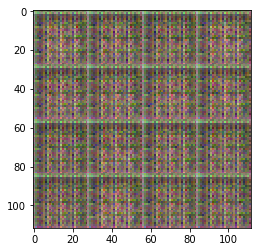

Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 2.8542
Epoch 1/1... Discriminator Loss: 0.2638... Generator Loss: 10.0732
Epoch 1/1... Discriminator Loss: 0.2615... Generator Loss: 2.7191
Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 2.4535
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.8289


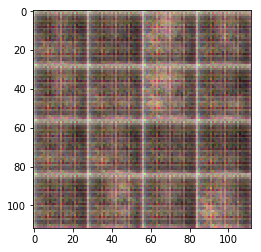

Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 1.7931
Epoch 1/1... Discriminator Loss: 0.3200... Generator Loss: 2.1936
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 1.7699
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 4.0802


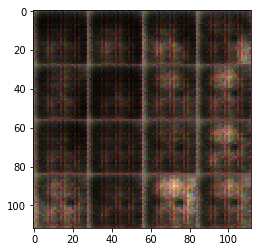

Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 1.7137
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 2.5588
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.2100
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 4.1395


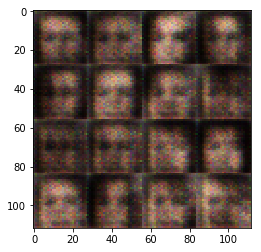

Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 1.8117
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 1.6373


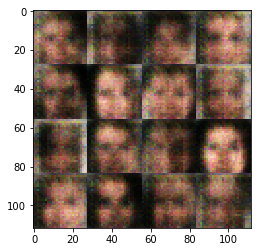

Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.3220... Generator Loss: 2.5658
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 2.9492
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 2.1563


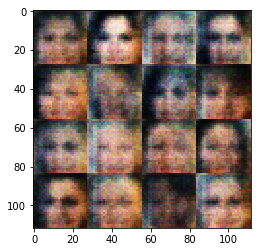

Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 2.5108
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 1.6145
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 2.2137


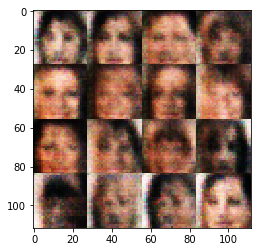

Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 3.8427
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 1.8275
Epoch 1/1... Discriminator Loss: 0.3498... Generator Loss: 2.0274
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 2.2647


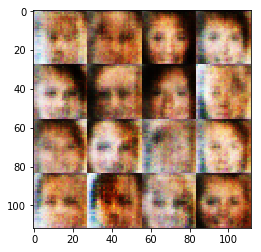

Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.8684
Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 2.0872
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.5877


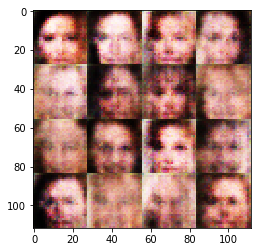

Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.8030
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 2.9253
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.2729


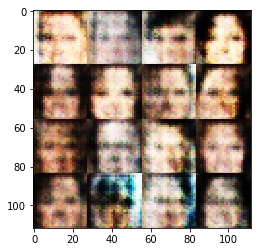

Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 2.8259
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 2.1362
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.7356


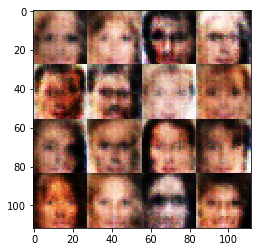

Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.4793
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.5593
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 2.8129
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 0.9327


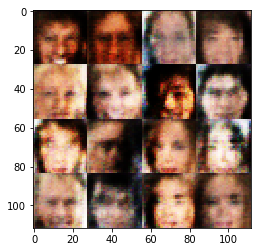

Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.7169
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 0.9886


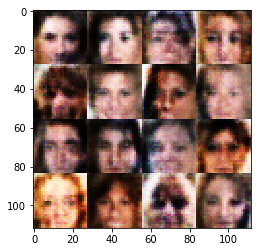

Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 2.3217
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 2.1593
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 1.5690


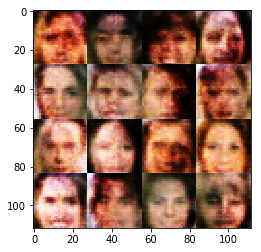

Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 1.7180
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 2.8536


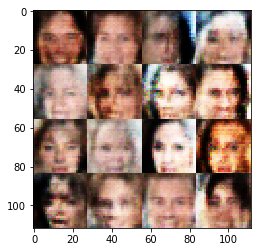

Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 2.7188
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.8889
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 3.1133
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 0.9092


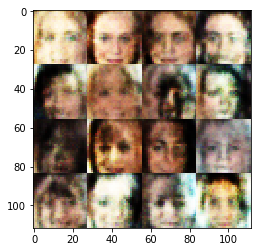

Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 2.9480
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 0.9795


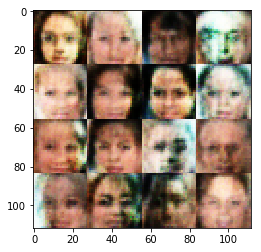

Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 1.7160
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.1936


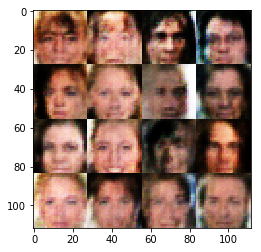

Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 1.8607
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 1.5753


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
alpha = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.